## 패키지 불러오기

In [1130]:
import os
import numpy as np
import cv2
from os.path import join
from glob import glob
import matplotlib.pyplot as plt
import skimage
import time
import math
from tqdm.notebook import tqdm
from skimage.morphology import skeletonize

import fingerprint as fp

## 이미지 불러오기

In [1131]:
train_path_zip = './train.zip'
test_path_zip = './test2.zip'

train_path = './train'
test_path = './test'

In [1132]:
from zipfile import ZipFile

# 압축 풀기
with ZipFile(train_path_zip, 'r') as zip_ref:
    zip_ref.extractall(train_path)

In [1133]:
# 압축 풀기
with ZipFile(test_path_zip, 'r') as zip_ref:
    zip_ref.extractall(test_path)

In [1165]:
train_list = sorted(glob(join(train_path, './*/*.BMP')))
train_list = [join('./train/train_ref/',os.path.basename(path.replace('\\', '/'))) for path in train_list]
#sorted(glob(join(train_path, './*/*.BMP')))
print(train_list[:10])

['./train/train_ref/1.BMP', './train/train_ref/10.BMP', './train/train_ref/100.BMP', './train/train_ref/101.BMP', './train/train_ref/102.BMP', './train/train_ref/104.BMP', './train/train_ref/105.BMP', './train/train_ref/106.BMP', './train/train_ref/107.BMP', './train/train_ref/108.BMP']


In [1166]:
test_list = sorted(glob(join(test_path, './*/*.BMP')))
test_list = [join('./test/test2/',os.path.basename(path.replace('\\', '/'))) for path in test_list]
#sorted(glob(join(test_path, './*/*.BMP')))
print(test_list[:10])

['./test/test2/100_type1.BMP', './test/test2/100_type2.BMP', './test/test2/100_type3.BMP', './test/test2/101_type1.BMP', './test/test2/101_type2.BMP', './test/test2/101_type3.BMP', './test/test2/102_type1.BMP', './test/test2/102_type2.BMP', './test/test2/102_type3.BMP', './test/test2/104_type1.BMP']


## 이미지 전처리

In [1147]:
# 이미지 이진화

def preprocess_binary(image_path):
    # 이미지 로드 및 그레이스케일 변환
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Normalize histogram
    normalized_img = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    
    # 히스토그램 평활화
    image = cv2.equalizeHist(image)
    
    # CLAHE 적용
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(10, 10))
    image = clahe.apply(image)
    
    # 미디언 필터 적용
    image = cv2.medianBlur(image, 3)
    
    # Otsu의 이진화
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    #Otsu의 이진화는 이미지의 히스토그램을 기반으로 자동으로 임계값을 결정하여 이미지를 이진화하는 방법
    
    return binary

In [1137]:
# 객체 추출

def extract_fingerprint_area(binary,visualize = False):
    
    # 3*3 커널정의
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    
    # 모폴로지 연산
    img_dil = cv2.dilate(binary, kernel, iterations=6)
    img_erode = cv2.erode(img_dil,kernel,iterations=6)
    
    
    
    # 경계 찾기
    contours, _ = cv2.findContours(img_erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 각 경계의 좌표 리스트 초기화
    boundary_coordinates = []
    
    # 각 경계의 좌표 저장
    for contour in contours:
        for point in contour:
            boundary_coordinates.append((point[0][0], point[0][1]))
    
    # 시각화가 true면
    if visualize == True:
        plt.imshow(img_erode, cmap='gray')
        # 시각화를 위해 경계를 빨간색으로 표시
        for contour in contours:
            x = [point[0][0] for point in contour]  # 윤곽선의 x 좌표들
            y = [point[0][1] for point in contour]  # 윤곽선의 y 좌표들
            plt.plot(x, y, color='red')  # 윤곽선 그리기
        plt.show()
     
    return img_erode,boundary_coordinates


In [1138]:
def preprocess_skeleton(binary):
    # 스켈레톤화
    skeleton = skeletonize(binary//150)
    skeleton = (skeleton * 255).astype(np.uint8)
        
    return skeleton

In [1139]:
def visualize_images(original, binary, skeleton):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(binary, cmap='gray')
    axes[1].set_title('Binarized Image')
    axes[1].axis('off')
    
    axes[2].imshow(skeleton, cmap='gray')
    axes[2].set_title('Skeletonized Image')
    axes[2].axis('off')
    
    plt.show()

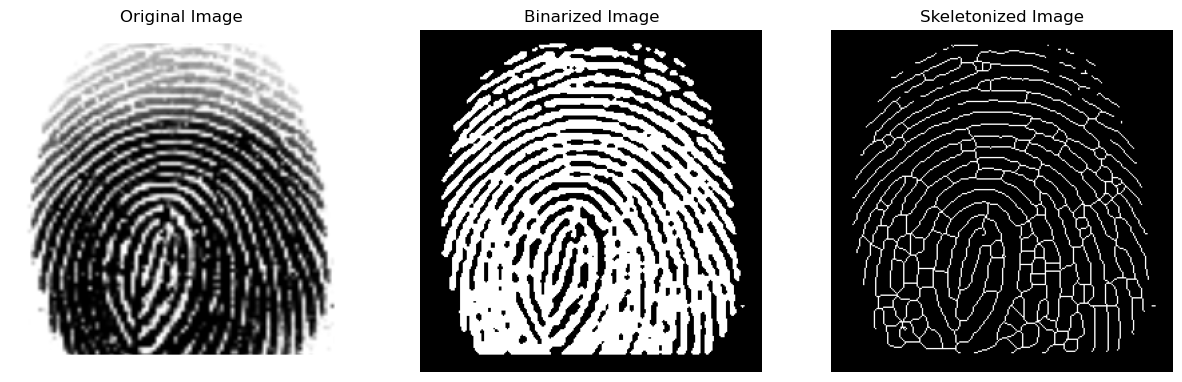

In [1158]:
# 출력해보자
original_image = cv2.imread(train_list[0], cv2.IMREAD_GRAYSCALE)
binary_image = preprocess_binary(train_list[0])
skeleton_image = preprocess_skeleton(binary_image)
                      
visualize_images(original_image, binary_image, skeleton_image)


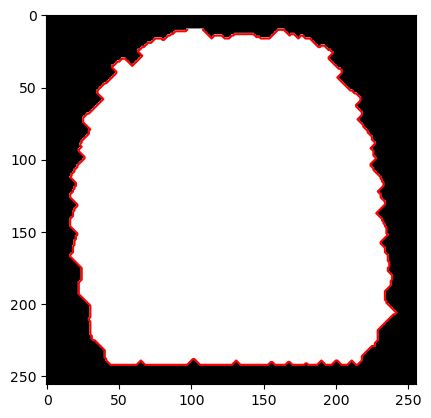

In [1141]:
bound_img,bound_coor=extract_fingerprint_area(binary_image,visualize=True )
#visualize_boundary(binary_image,bound_coor)

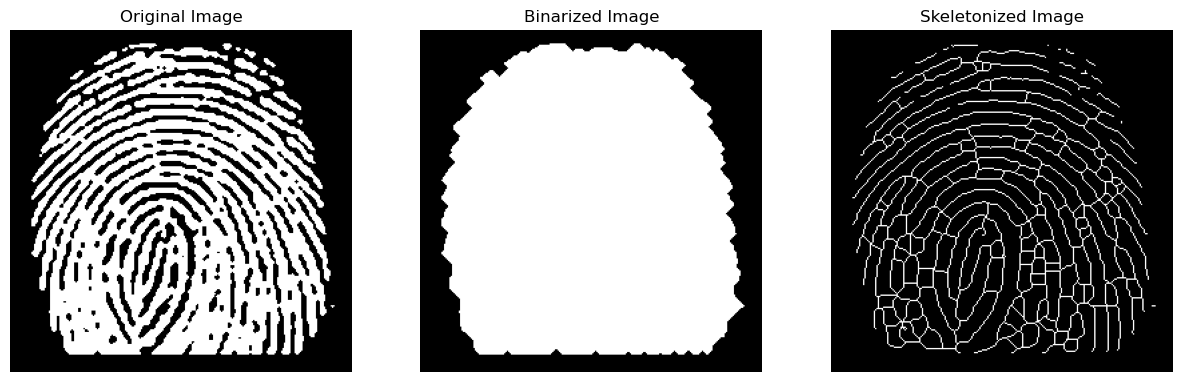

In [1142]:
visualize_images(binary_image, bound_img, skeleton_image)

## Train and Test
바이너리, 바운드, 스켈레톤

In [1063]:
list_train_skeleton=[]
list_train_bound = []
for path in tqdm(train_list):
    train_binary = preprocess_binary(path)
    train_bound_img, train_bound_coor= extract_fingerprint_area(train_binary)
    list_train_bound.append(train_bound_coor)
    train_skeleton = preprocess_skeleton(train_binary)
    list_train_skeleton.append(train_skeleton)

  0%|          | 0/477 [00:00<?, ?it/s]

In [1064]:
list_test_skeleton=[]
list_test_bound = []
for path in tqdm(test_list):
    test_binary = preprocess_binary(path)
    test_bound_img,test_bound_coor= extract_fingerprint_area(test_binary)
    list_test_bound.append(test_bound_coor)
    test_skeleton = preprocess_skeleton(test_binary)
    list_test_skeleton.append(test_skeleton)

  0%|          | 0/1428 [00:00<?, ?it/s]

In [1065]:
len(list_train_bound)

477

# Feature extraction

In [1066]:
def extract_minutiae(skeleton):
    minutiae = {'endpoints': [], 'bifurcations': []}
    rows, cols = skeleton.shape
    
    # 3x3 윈도우로 이미지 순회
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if skeleton[i, j] == 255: #중심이 하양이고
                # 3x3 윈도우
                window = skeleton[i-1:i+2, j-1:j+2]
                # 이웃한 픽셀 개수 세기
                count = np.sum(window)/255 - 1
                # 끝점: 이웃한 픽셀 1개
                if count == 1:
                    minutiae['endpoints'].append((i, j))
                # 분기점: 이웃한 픽셀 3개
                elif count == 3:
                    minutiae['bifurcations'].append((i, j))
    
    return minutiae

In [1230]:
def remove_contour(minutiae, boundary_coordinates):
   
    # 중복 제거를 위해 새로운 미누티아 리스트 생성
    unique_minutiae_endpoint = []
    unique_minutiae_bifurcation= []
    
    # 각 미누티아의 위치가 컨투어와 겹치는지 확인하고 중복 제거
    for endpoint in minutiae['endpoints']:
        # 컨투어와 중복되지 않는 좌표 확인
        unique = True
        for bound in boundary_coordinates:
            if np.all(np.abs(np.array(endpoint) - np.array(bound)) <= 5):
                unique = False
                break
        
        # 중복되지 않는 경우만 추가
        if unique:
            unique_minutiae_endpoint.append(endpoint)
            
            
    for bifurcation in minutiae['bifurcations']:
        # 컨투어와 중복되지 않는 좌표 확인
        unique = True
        for bound in boundary_coordinates:
            if np.all(np.abs(np.array(bifurcation) - np.array(bound)) <= 8):
                unique = False
                break
        
        # 중복되지 않는 경우만 추가
        if unique:
            unique_minutiae_bifurcation.append(bifurcation)
            
    # 중복을 제거한 미누티아들로 기존 미누티아를 업데이트
    minutiae['endpoints'] = unique_minutiae_endpoint
    minutiae['bifurcations'] = unique_minutiae_bifurcation

    return minutiae


In [1231]:
def visualize_minutiae(image, minutiae):
    #image = (image * 255).astype(np.uint8)
    # 엔드 포인트와 분기점을 시각화하기 위한 이미지 복사
    image_with_minutiae = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # 엔드 포인트 시각화 (빨간 점)
    for endpoint in minutiae['endpoints']:
        cv2.circle(image_with_minutiae, endpoint[::-1], 1, (0, 0, 255), -1)
    
    # 분기점 시각화 (파란 점)
    for bifurcation in minutiae['bifurcations']:
        cv2.circle(image_with_minutiae, bifurcation[::-1], 1, (0, 255, 0), -1)
    
    # 결과 시각화
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(image_with_minutiae, cv2.COLOR_BGR2RGB))
    plt.title('Minutiae Visualization')
    plt.axis('off')
    plt.show()

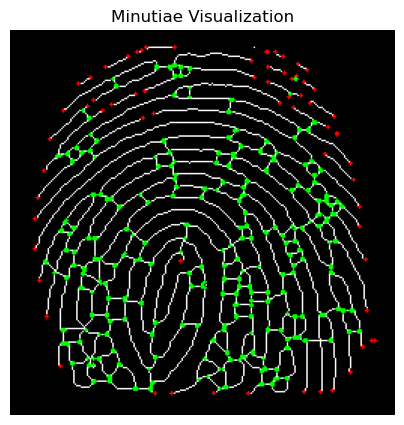

In [1232]:
# 엔드 포인트와 분기점 찾기

minutiae = extract_minutiae(skeleton_image)
#print(minutiae)
# 결과 시각화
visualize_minutiae(skeleton_image , minutiae)

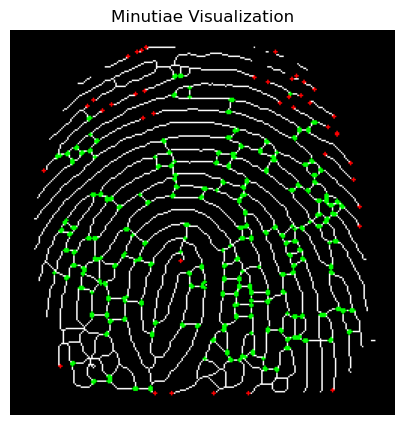

In [1233]:
remove_contour_final = remove_contour(minutiae, bound_coor)
# 결과 시각화
visualize_minutiae(skeleton_image, remove_contour_final)


## Matching

In [1234]:
# 리스트 길이 확인
print(f'Length of list_train_skeleton: {len(list_train_skeleton)}')
print(f'Length of list_train_bound: {len(list_train_bound)}')

Length of list_train_skeleton: 477
Length of list_train_bound: 477


In [1279]:
list_train_feature_extract = []

for i in tqdm(range(len(list_train_skeleton))):
    train_minutiae = {}
    train_minutiae = extract_minutiae(list_train_skeleton[i])
    train_minutiae = remove_contour(train_minutiae,list_train_bound[i])
    list_train_feature_extract.append(train_minutiae)
    

  0%|          | 0/477 [00:00<?, ?it/s]

In [1156]:
list_test_feature_extract = []

for i in tqdm(range(len(list_test_skeleton))):
    test_minutiae = extract_minutiae(list_test_skeleton[i])
    test_minutiae = remove_contour(test_minutiae,list_test_bound[i])
    list_test_feature_extract.append(test_minutiae)

  0%|          | 0/1428 [00:00<?, ?it/s]

## Matching

In [1212]:
def match_minutiae(list_train_feature_extract, test_minutiae, threshold=2):
    
    best_matches = None
    best_matching_score = 0
    best_idx = 0

    # 테스트 데이터의 특징점들을 넘파이 배열로 변환
    if isinstance(test_minutiae, dict):
        test_endpoints = np.array(test_minutiae['endpoints'])
        test_bifurcations = np.array(test_minutiae['bifurcations'])
    else:
        test_endpoints = np.array(test_minutiae)
        test_bifurcations = np.array(test_minutiae)

    num_feat_query = len(test_endpoints) + len(test_bifurcations)

    for idx, train_minutiae in enumerate(list_train_feature_extract):
        # 훈련 데이터의 특징점들을 넘파이 배열로 변환
        if isinstance(train_minutiae, dict):
            train_endpoints = np.array(train_minutiae['endpoints'])
            train_bifurcations = np.array(train_minutiae['bifurcations'])
        else:
            train_endpoints = np.array(train_minutiae)
            train_bifurcations = np.array(train_minutiae)

        num_feat_train = len(train_endpoints) + len(train_bifurcations)

        # 거리 계산
        if train_endpoints.size > 0 and test_endpoints.size > 0:
            endpoint_distances = np.sqrt(np.sum((train_endpoints[:, np.newaxis] - test_endpoints)**2, axis=2))
            endpoint_matches = np.argwhere(endpoint_distances <= threshold)
        else:
            endpoint_matches = []

        if train_bifurcations.size > 0 and test_bifurcations.size > 0:
            bifurcation_distances = np.sqrt(np.sum((train_bifurcations[:, np.newaxis] - test_bifurcations)**2, axis=2))
            bifurcation_matches = np.argwhere(bifurcation_distances <= threshold)
        else:
            bifurcation_matches = []

        # 매칭된 특징점 쌍을 딕셔너리에 저장하고 반환
        matches = {
            'endpoints': [(train_endpoints[i], test_endpoints[j]) for i, j in endpoint_matches],
            'bifurcations': [(train_bifurcations[i], test_bifurcations[j]) for i, j in bifurcation_matches]
        }

        # 유사성 계산
        num_matches = len(endpoint_matches) + len(bifurcation_matches)
        matching_score = num_matches / ((num_feat_query + num_feat_train) / 2)

        # 최고 유사성 갱신
        if matching_score > best_matching_score:
            best_matching_score = matching_score
            best_matches = matches
            best_idx = idx

    return best_matches, best_matching_score, best_idx


In [1255]:
def visualize_matches(train_path, test_path, matches):
    
    train_img = cv2.imread(train_path, cv2.IMREAD_GRAYSCALE)
    test_img = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
    
    combined_img = np.concatenate((train_img, test_img), axis=1)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(combined_img, cmap='gray')

    offset = train_img.shape[1]
    colors = ['b', 'r']  # 엔드포인트는 파란색, 분기점은 빨간색
    
    for i, (train_point, test_point) in enumerate(matches['endpoints']):
        plt.plot([train_point[1], test_point[1] + offset], [train_point[0], test_point[0]], color=colors[1], linestyle='-', marker='o',markersize=1.5,linewidth=0.2)

    for i, (train_point, test_point) in enumerate(matches['bifurcations']):
        plt.plot([train_point[1], test_point[1] + offset], [train_point[0], test_point[0]], color=colors[0], linestyle='-', marker='o',markersize=1.5,linewidth=0.2)

    plt.show()

In [1258]:
result={}
idx_test = 0
for test in tqdm(list_test_feature_extract):
    best_matches,matching_score,idx_train = match_minutiae(list_train_feature_extract,test)
    result[test_list[idx_test]] = [idx_train,train_list[idx_train], matching_score]
    idx_test+=1
    

  0%|          | 0/1428 [00:00<?, ?it/s]

In [1262]:
result

{'./test/test2/100_type1.BMP': [2,
  './train/train_ref/100.BMP',
  2.2062643239113826],
 './test/test2/100_type2.BMP': [2,
  './train/train_ref/100.BMP',
  2.1308258381030254],
 './test/test2/100_type3.BMP': [2,
  './train/train_ref/100.BMP',
  2.3533173461231014],
 './test/test2/101_type1.BMP': [3,
  './train/train_ref/101.BMP',
  1.7120786516853932],
 './test/test2/101_type2.BMP': [3,
  './train/train_ref/101.BMP',
  2.00724112961622],
 './test/test2/101_type3.BMP': [3,
  './train/train_ref/101.BMP',
  2.2649388048956083],
 './test/test2/102_type1.BMP': [4,
  './train/train_ref/102.BMP',
  1.9529737206085753],
 './test/test2/102_type2.BMP': [4,
  './train/train_ref/102.BMP',
  1.8057971014492753],
 './test/test2/102_type3.BMP': [4,
  './train/train_ref/102.BMP',
  2.2027027027027026],
 './test/test2/104_type1.BMP': [5,
  './train/train_ref/104.BMP',
  1.840620592383639],
 './test/test2/104_type2.BMP': [5,
  './train/train_ref/104.BMP',
  1.5982658959537572],
 './test/test2/104_type3

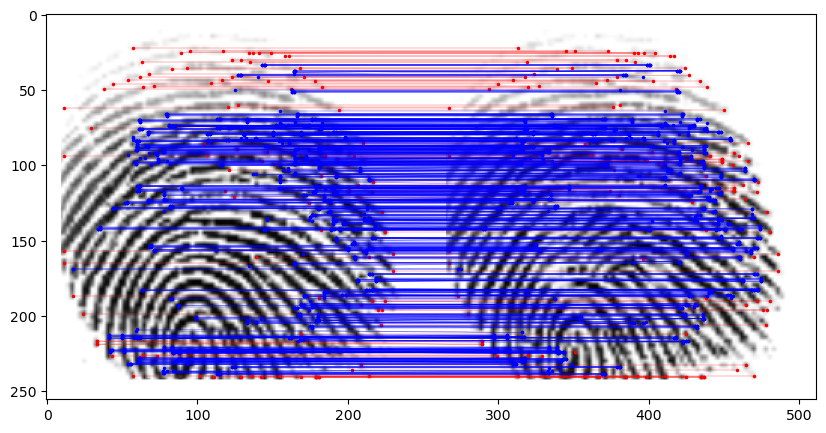

In [1271]:
index_num=420
best_matches,matching_score,idx_train = match_minutiae(list_train_feature_extract,list_test_feature_extract[index_num])
visualize_matches(train_list[idx_train], test_list[index_num], best_matches)

In [1264]:
def calculate_metrics(data):
    # 가공된 데이터 저장용
    processed_data = {}

    # 데이터 가공
    for key, value in data.items():
        test_file = key.split('/')[-1]
        ref_file = value[1].split('/')[-1]
        if ref_file == '100.BMP':
            processed_data[test_file] = ref_file

    # True Positive, False Positive, True Negative, False Negative 초기화
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # 테스트 데이터셋의 참조 값
    reference = '100.BMP'

    for test_file, ref_file in processed_data.items():
        if test_file.startswith('100'):
            if ref_file == reference:
                TP += 1
            else:
                FN += 1
        else:
            if ref_file == reference:
                FP += 1
            else:
                TN += 1

    # 성능 지표 계산
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    far = FP / (FP + TN) if (FP + TN) > 0 else 0
    frr = FN / (TP + FN) if (TP + FN) > 0 else 0
    accuracy = (TP + TN) / (TP + FP + TN + FN) if (TP + FP + TN + FN) > 0 else 0

    return precision, recall, far, frr, accuracy


In [1265]:

precision, recall, far, frr, accuracy = calculate_metrics(result)

# 결과 출력
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"FAR: {far}")
print(f"FRR: {frr}")
print(f"Accuracy: {accuracy}")


Precision: 1.0
Recall: 1.0
FAR: 0
FRR: 0.0
Accuracy: 1.0
